In [1]:
!pip install wfdb
!pip install biosppy
!pip install opencv-python

In [2]:
from __future__ import division, print_function

import json
import sys
import os
from glob import glob
import re
import wfdb
import cv2
import pandas as pd
import numpy as np
import biosppy
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import History
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, ELU, Dropout, Dense, Flatten
from tensorflow.keras import backend as K
import tensorflow as tf


TRAIN_PATH = 'train-imgs/'
LABEL_TRAIN_PATH = 'labels-train.txt'

TEST_PATH = 'test-imgs/'
LABEL_TEST_PATH = 'labels-test.txt'

# Dataset overview

In [3]:
def plot_record(record, index):
    fig, ax = plt.subplots(nrows=2, figsize=(18,6))
    I = record[0][:, 0]
    II = record[0][:, 1]

    ax[0].plot(I)
    ax[1].plot(II)
    ax[0].set_ylabel('Lead II ' + index, color='B', fontweight='bold', fontsize='large')
    ax[1].set_xlabel('Datapoints' + index, color='B', fontweight='bold', fontsize='large')
    ax[1].set_ylabel('Lead II' + index, color='B', fontweight='bold', fontsize='large')

In [4]:
# for file in get_file_indexes():
#     plot_record(wfdb.rdsamp('mitdb/' + file, sampto=1000), file)

In [5]:
class_to_idx = {
    'apc': 0,
    'nor': 1, 
    'lbb': 2, 
    'pab': 3, 
    'pvc': 4, 
    'rbb': 5,  
    'veb': 6, 
    'vfw': 7
}
symbol_to_label = {
    'N':'nor', 
    'L':'lbb', 
    'R':'rbb', 
    'A':'apc', 
    'V':'pvc', 
    '/':'pab', 
    'E':'veb', 
    '!':'vfw'
}
idx_to_class = dict(zip(class_to_idx.values(), class_to_idx.keys()))

# Prepare test dataset

In [6]:
test_paths = glob(TEST_PATH + '*.png')

cropped_test_paths = {}
begining = test_paths[0].rfind('/') + 1
nums = []
for path in test_paths:
    end = path.rfind('.')
    
    number = path[begining:end]
    nums.append(number)
    record_n = int(number[:number.find('_')])
    sig_n = int(number[number.find('_') + 1:])
    
    if cropped_test_paths.get(record_n) is None:
        cropped_test_paths[record_n] = 0
    cropped_test_paths[record_n] += 1

In [7]:
dict(sorted(cropped_test_paths.items()))

{0: 1863, 1: 2567, 2: 1873, 3: 2278, 4: 1580, 5: 1853, 6: 2618, 7: 1948}

In [8]:
id_labels_test = {}
count = 0
lines = 0
with open(LABEL_TEST_PATH, 'r') as f:
    for line in f:
        lines += 1
        n, l = line.split()
        if n in nums:
            count += 1
        id_labels_test[n] = int(l)

len(id_labels_test)
print(count)
print(len(nums))
print(lines)

16973
16580
16973


In [15]:
labels = np.array(list(id_labels_test.values()))
NUM_CLASSES = len(np.unique(labels))

indices = np.arange(len(labels))
np.random.seed(123)
np.random.shuffle(indices)

In [16]:
def get_cropping_images(image):
    #Left Top Crop
    left_top = cv2.resize(image[:96, :96], (128, 128))

    #Center Top Crop
    center_top = cv2.resize(image[:96, 16:112], (128, 128))

    #Right Top Crop
    right_top = cv2.resize(image[:96, 32:], (128, 128))

    #Left Center Crop
    left_center = cv2.resize(image[16:112, :96], (128, 128))

    #Center Center Crop
    center_center = cv2.resize(image[16:112, 16:112], (128, 128))

    #Right Center Crop    
    right_center = cv2.resize(image[16:112, 32:], (128, 128))

    #Left Bottom Crop
    left_bottom = cv2.resize(image[32:, :96], (128, 128))

    #Center Bottom Crop
    center_bottom = cv2.resize(image[32:, 16:112], (128, 128))

    #Right Bottom Crop    
    right_bottom = cv2.resize(image[32:, 32:], (128, 128))

    return np.array([left_top, center_top, right_top,
            left_center, center_center, right_center,
            left_bottom, center_bottom, right_bottom])

In [17]:
def get_generator(ind, augment=False):
    image = cv2.imread(test_paths[ind], cv2.IMREAD_GRAYSCALE)
    number_path = test_paths[ind][test_paths[ind].rfind('/') + 1 : test_paths[ind].rfind('.')]
   
    label = id_labels_test[number_path]
    
    if augment and label != class_to_idx['nor']:
        cropped_images = get_cropping_images(image)
        images = np.vstack((np.expand_dims(image, axis=0), cropped_images)) 
        yield images, [label] * len(images)
    else:
        yield np.expand_dims(image, 0), [label]

In [18]:
def raw_batch_generator(batch_size, augment=False, debug=False):
    global batch_i
    
    generators = np.array([get_generator(ind, augment) for ind in range(len(test_paths))])
    while True:
        batch_indices = indices[(batch_i - 1) * batch_size : batch_i * batch_size]
        batch_i += 1
        yield [gen.__next__() for gen in generators[batch_indices]]

In [19]:
def images_and_labels_generator(batch_size, augment=False):
    for batch in raw_batch_generator(batch_size, augment):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(e[0])
            batch_labels.extend(e[1])
        batch_images = np.stack(batch_images, axis=0) if not augment else np.vstack(batch_images)
        yield batch_images, batch_labels

In [22]:
def train_iterator_test(batch_size, augment=False):      
    for batch in images_and_labels_generator(batch_size, augment):
        batch_images = batch[0]
        batch_images = np.expand_dims(batch_images, -1)
        batch_labels = keras.utils.to_categorical(batch[1], NUM_CLASSES)
        yield batch_images, batch_labels

In [23]:
import keras

batch_i = 1
train_iterator_test(32, augment=True).__next__()[0].shape

(140, 128, 128, 1)

# Prepare train dataset

## Get images paths and get images IDs from the paths

In [24]:
train_paths = glob(TRAIN_PATH + '*.png')

cropped_train_paths = {}
begining = train_paths[0].rfind('/') + 1

for path in train_paths:
    end = path.rfind('.')
    
    number = path[begining:end]
    record_n = int(number[:number.find('_')])
    sig_n = int(number[number.find('_') + 1:])
    
    if cropped_train_paths.get(record_n) is None:
        cropped_train_paths[record_n] = 0
    cropped_train_paths[record_n] += 1

In [26]:
id_labels_train = {}
with open(LABEL_TRAIN_PATH, 'r') as f:
    for line in f:
        n, l = line.split()
        id_labels_train[n] = int(l)

len(id_labels_train)

91088

In [27]:
labels = np.array(list(id_labels_train.values()))
NUM_CLASSES = len(np.unique(labels))

indices = np.arange(len(labels))
np.random.seed(123)
np.random.shuffle(indices)

## Tha dataset is imbalanced, so we'll need to artificially augment smaller classes

In [28]:
a = np.unique(list(id_labels_train.values()), return_counts=True)

In [29]:
a[0]

array([0, 1, 2, 3, 4, 5, 6, 7])

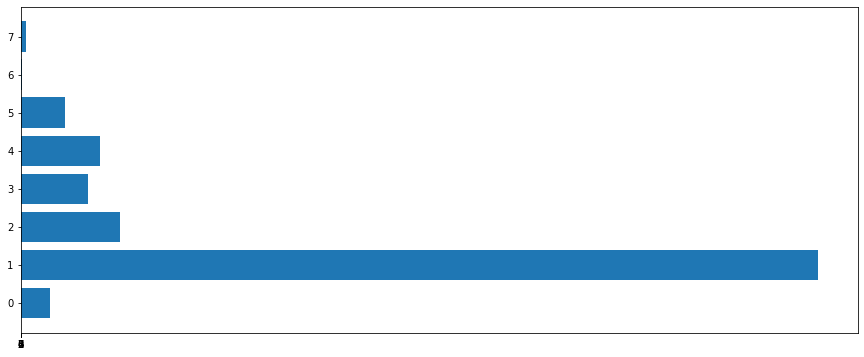

In [30]:
objects = a[0]
y_pos = np.arange(len(objects))
performance = a[1]

plt.figure(figsize=(15,6))
plt.barh(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.show()

In [31]:
r = np.unique(list(id_labels_train.values()), return_counts=True)

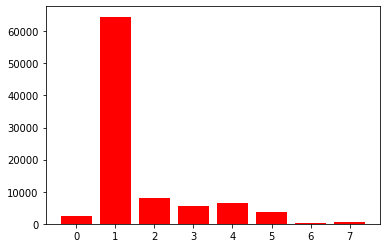

In [32]:
height = r[1]
bars = r[0]
y_pos = np.arange(len(bars))


plt.bar(y_pos, height, color=['red'])
plt.xticks(y_pos, bars)
plt.show()

# Balancing the dataset

## This method augments smaller classes ten times cropping and shifting images

In [33]:
def get_cropping_images(image):
    #Left Top Crop
    left_top = cv2.resize(image[:96, :96], (128, 128))

    #Center Top Crop
    center_top = cv2.resize(image[:96, 16:112], (128, 128))

    #Right Top Crop
    right_top = cv2.resize(image[:96, 32:], (128, 128))

    #Left Center Crop
    left_center = cv2.resize(image[16:112, :96], (128, 128))

    #Center Center Crop
    center_center = cv2.resize(image[16:112, 16:112], (128, 128))

    #Right Center Crop    
    right_center = cv2.resize(image[16:112, 32:], (128, 128))

    #Left Bottom Crop
    left_bottom = cv2.resize(image[32:, :96], (128, 128))

    #Center Bottom Crop
    center_bottom = cv2.resize(image[32:, 16:112], (128, 128))

    #Right Bottom Crop    
    right_bottom = cv2.resize(image[32:, 32:], (128, 128))

    return np.array([left_top, center_top, right_top,
            left_center, center_center, right_center,
            left_bottom, center_bottom, right_bottom])

To be consistent with the 1D test/train split, we'll define a list of test indexes corresponding to their records

1D list: ```['101', '105', '114', '118', '124', '201', '210', '217']```  
2D list: ```[1, 5, 13, 17, 22, 24, 31, 36]```

In [34]:
def get_generator(ind, augment=False):
    image = cv2.imread(train_paths[ind], cv2.IMREAD_GRAYSCALE)
    number_path = train_paths[ind][train_paths[ind].rfind('/') + 1 : train_paths[ind].rfind('.')]
   
    label = id_labels_train[number_path]
    
    if augment and label != class_to_idx['nor']:
        cropped_images = get_cropping_images(image)
        images = np.vstack((np.expand_dims(image, axis=0), cropped_images)) 
        yield images, [label] * len(images)
    else:
        yield np.expand_dims(image, 0), [label]

In [35]:
def raw_batch_generator(batch_size, augment=False, debug=False):
    global batch_i
    
    generators = np.array([get_generator(ind, augment) for ind in range(len(train_paths))])
    while True:
        batch_indices = indices[(batch_i - 1) * batch_size : batch_i * batch_size]
        batch_i += 1
        yield [gen.__next__() for gen in generators[batch_indices]]

In [36]:
def images_and_labels_generator(batch_size, augment=False):
    for batch in raw_batch_generator(batch_size, augment):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(e[0])
            batch_labels.extend(e[1])
        batch_images = np.stack(batch_images, axis=0) if not augment else np.vstack(batch_images)
        yield batch_images, batch_labels

In [37]:
def train_iterator(batch_size, augment=False):      
    for batch in images_and_labels_generator(batch_size, augment):
        batch_images = batch[0]
        batch_images = np.expand_dims(batch_images, -1)
        batch_labels = keras.utils.to_categorical(batch[1], NUM_CLASSES)
        yield batch_images, batch_labels

In [38]:
!pip install Keras

In [39]:
len(id_labels_train)

91088

In [40]:
len(train_paths)

91088

In [41]:
import keras

batch_i = 1
train_iterator(32, augment=True).__next__()[0].shape

(149, 128, 128, 1)

# CNN Model

In [ ]:
class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name
        self.f1s = []
        
    def on_epoch_end(self, epoch, logs=None):     
        model_filename = self.file_name.format(epoch % 3)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))
        return

## Custom F1 score mectric for measuring training quality

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1_val = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
            
    return f1_val

## Define parameters for CNN training

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
STEPS_PER_EPOCH = 10
EPOCHS = 10

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3),strides=(1,1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3),strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, (3, 3), strides = (1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3),strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3),strides=(1, 1),kernel_initializer='glorot_uniform'))
model.add(ELU())
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(2048))
model.add(ELU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))

model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',  # gradient clipping just in case
  metrics=['accuracy'] 
)

## Count class weights to cope with imbalanced dataset during training

In [ ]:
labels_for_weights = labels
for ind in [0, 2, 3, 4, 5, 6, 7]:
    new_labels = np.full(sum(labels == ind) * 9, ind)
    labels_for_weights = np.append(labels_for_weights, new_labels)
print("Weights: " + str(len(labels_for_weights)))

class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_for_weights), labels_for_weights)
print(class_weights)

In [ ]:
MODEL_FNAME = 'model_v3_{}'

In [ ]:
def train_from_n_epoch(initial_epoch, load_fname):
    global batch_i
    global hist
    
    batch_i = initial_epoch * STEPS_PER_EPOCH + 1
    hist = History()
    model = load_model(load_fname, custom_objects={'f1':f1})

    model.fit_generator(
        train_iterator(BATCH_SIZE, augment=True), 
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        callbacks=[ModelSaveCallback(MODEL_FNAME), hist],
        verbose=1,  
        class_weight=class_weights,
        initial_epoch=initial_epoch
    )

In [ ]:
batch_i = 1
hist = History()

H = model.fit(
    train_iterator(BATCH_SIZE, True), 
    epochs=3,
    callbacks=[ModelSaveCallback(MODEL_FNAME), hist],
    verbose=1,  
    class_weight=class_weights,
    initial_epoch=0
)

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["acc"], label="train_acc")
plt.plot(H.history["val_acc"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
with open('f1_scores.txt', 'a') as fout:
    for val in hist.history['f1']:
        fout.write(str(val) + '\n')
        
with open('cat_accuracies.txt', 'a') as fout:
    for val in hist.history['categorical_accuracy']:
        fout.write(str(val) + '\n')

# Quality

In [ ]:
def predict_iterator(paths_test):
    for i in range(len(paths_test)):
        image = cv2.imread(paths_test[i], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, -1)
        yield np.expand_dims(image, 0

In [ ]:
labels_test = []
for path in all_paths:
    img_n = path[path.rfind('/') + 1 : path.rfind('.')]
    labels_test.append(n_l[img_n])

In [ ]:
preds = model.predict_generator(predict_iterator(all_paths), steps=len(all_paths), verbose=1)

In [ ]:
labels_pred = np.argmax(preds, axis=1)
labels_pred[:10]

## Calculate confusion matrix and f1-score for each class

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
%matplotlib inline

In [ ]:
conf_mtx = confusion_matrix(labels_test, labels_pred, labels=np.arange(8))

In [ ]:
x = []
for i in range(NUM_CLASSES):
    x.append(idx_to_class[i].upper())

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = sns.heatmap(conf_mtx_1, annot=True, fmt='d', cmap=sns.cm.rocket_r, 
                 xticklabels=x, yticklabels=x, robust=True, 
                 linewidths=0.1, linecolor='grey')

In [ ]:
f1_scores = f1_score(labels_pred, labels_test, average=None)
f1_scores

In [ ]:
np.mean(f1_scores)